# Problématique

SNCF-Transilien, l'opérateur des trains de banlieue d'Île-de-France, cherche à mieux anticiper l'augmentation du nombre de validations de cartes à puce par jour et par gare. Cette anticipation est cruciale pour améliorer la performance opérationnelle et proposer des services plus adaptés. Entre 2015 et 2019, le nombre de validations a augmenté d'environ 6% par an. Le but de ce challenge est de prédire le nombre de validations par jour et par gare à moyen et long terme.

## Objectif


L'objectif principal est de développer un modèle de machine learning capable de prédire le nombre de validations quotidiennes pour chaque gare du réseau SNCF-Transilien sur la période du 1er janvier 2023 au 30 juin 2023.

## 1. Importation et Prétraitement des Données

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
import shap

# Importation des fichiers de données
train_data = pd.read_csv('data/train_f_x.csv')
test_data = pd.read_csv('data/test_f_x_THurtzP.csv')
y_train = pd.read_csv('data/y_train_sncf.csv')
y_example = pd.read_csv('data/y_exemple_sncf_d9so9pm.csv')

# Ajouter une colonne 'index' dans train_data pour correspondre à y_train
train_data['index'] = train_data['date'].astype(str) + '_' + train_data['station']
test_data['index'] = test_data['date'].astype(str) + '_' + test_data['station']

# Fusionner les données de validation avec les données de train
train_data = train_data.merge(y_train, on='index', how='left')
test_data = test_data.merge(y_example, on='index', how='left')

# Conversion des colonnes 'date' en format datetime
train_data['date'] = pd.to_datetime(train_data['date'])
test_data['date'] = pd.to_datetime(test_data['date'])

# Ajout de variables exogènes
train_data['day_of_week'] = train_data['date'].dt.dayofweek
test_data['day_of_week'] = test_data['date'].dt.dayofweek
train_data['month'] = train_data['date'].dt.month
test_data['month'] = test_data['date'].dt.month
train_data['weekofyear'] = train_data['date'].dt.isocalendar().week
test_data['weekofyear'] = test_data['date'].dt.isocalendar().week

# Filtrer les stations avec au moins deux ans de données
sufficient_data_stations = train_data.groupby('station').filter(lambda x: len(x) >= 2 * 365)['station'].unique()
train_data = train_data[train_data['station'].isin(sufficient_data_stations)]
test_data = test_data[test_data['station'].isin(sufficient_data_stations)]

# Normalisation des données
features = ['job', 'ferie', 'vacances', 'day_of_week', 'month', 'weekofyear']
scaler = StandardScaler()
train_data[features] = scaler.fit_transform(train_data[features])
test_data[features] = scaler.transform(test_data[features])

# Séparer en ensembles d'entraînement et de validation
X_train, X_val, y_train, y_val = train_test_split(train_data[features], train_data['y'], test_size=0.2, random_state=42)

# Réduction de dimensionnalité avec PCA
pca = PCA(n_components=2)
train_pca = pca.fit_transform(train_data[features])
test_pca = pca.transform(test_data[features])

# Ajout des composantes principales aux données
train_data['pca1'] = train_pca[:, 0]
train_data['pca2'] = train_pca[:, 1]
test_data['pca1'] = test_pca[:, 0]
test_data['pca2'] = test_pca[:, 1]

# Échantillonnage des données pour éviter MemoryError
train_sample = train_data.sample(n=50000, random_state=42)


c:\Users\naiml\Desktop\M272\ML\Machine-Learning\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 2. Modèle de Référence : Régression Logistique

In [2]:
# Régression logistique
logistic_regression = LogisticRegression(max_iter=5)
logistic_regression.fit(train_sample[['pca1', 'pca2']], train_sample['y'])

# Prédictions
logistic_predictions = logistic_regression.predict(test_data[['pca1', 'pca2']])

# Calculer la MAPE pour la régression logistique
test_data['logistic_pred'] = logistic_predictions
mape_logistic = mean_absolute_percentage_error(test_data['y'], test_data['logistic_pred'])
print(f'MAPE Logistic Regression: {mape_logistic}')


c:\Users\naiml\Desktop\M272\ML\Machine-Learning\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


MAPE Logistic Regression: 0.9988623651771958


## 3. Modèle Non Supervisé : K-means

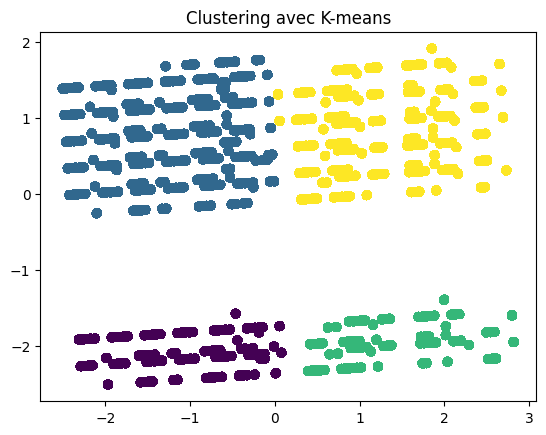

In [3]:
# Clustering avec K-means
kmeans = KMeans(n_clusters=4, random_state=42)
kmeans.fit(train_data[['pca1', 'pca2']])

# Ajouter les clusters aux données
train_data['cluster'] = kmeans.labels_
test_data['cluster'] = kmeans.predict(test_data[['pca1', 'pca2']])

# Afficher les clusters
plt.scatter(train_data['pca1'], train_data['pca2'], c=train_data['cluster'], cmap='viridis')
plt.title('Clustering avec K-means')
plt.show()


## 4. Modèle Supervisé : SVM avec Validation Croisée

In [4]:
# Définir les hyperparamètres pour le SVM
param_grid = {'C': [0.1, 1, 10], 'gamma': [1, 0.1, 0.01], 'kernel': ['rbf', 'linear']}

# Initialiser le modèle SVM
svm = SVR()

# Appliquer GridSearchCV pour trouver les meilleurs hyperparamètres
grid_search = GridSearchCV(svm, param_grid, cv=5, scoring='neg_mean_absolute_percentage_error', n_jobs=-1)
grid_search.fit(train_sample[['pca1', 'pca2']], train_sample['y'])

# Afficher les meilleurs hyperparamètres
best_svm = grid_search.best_estimator_
print("Best hyperparameters:", grid_search.best_params_)

# Prédictions avec le SVM optimisé
svm_predictions = best_svm.predict(test_data[['pca1', 'pca2']])

# Calculer la MAPE pour le SVM
test_data['svm_pred'] = svm_predictions
mape_svm = mean_absolute_percentage_error(test_data['y'], test_data['svm_pred'])
print(f'MAPE SVM: {mape_svm}')


Best hyperparameters: {'C': 10, 'gamma': 1, 'kernel': 'rbf'}
MAPE SVM: 0.8784313076295902


## 5. Interprétation des Modèles avec SHAP

100%|██████████| 77880/77880 [16:27<00:00, 78.86it/s]


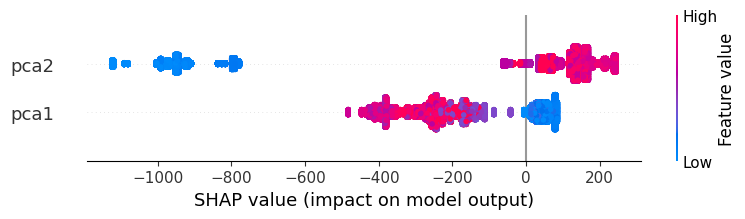

In [5]:
# Utiliser shap.sample pour réduire l'échantillon des données d'arrière-plan
background_sample = shap.sample(train_sample[['pca1', 'pca2']], 2)

# Calcul des valeurs SHAP pour le modèle SVM
explainer = shap.KernelExplainer(best_svm.predict, background_sample)
shap_values = explainer.shap_values(test_data[['pca1', 'pca2']])

# Visualiser les valeurs SHAP
shap.summary_plot(shap_values, test_data[['pca1', 'pca2']])


## 6. Comparaison des Performances

In [6]:
# Comparaison des performances
print(f'MAPE Logistic Regression: {mape_logistic}')
print(f'MAPE SVM: {mape_svm}')


MAPE Logistic Regression: 0.9988623651771958
MAPE SVM: 0.8784313076295902
